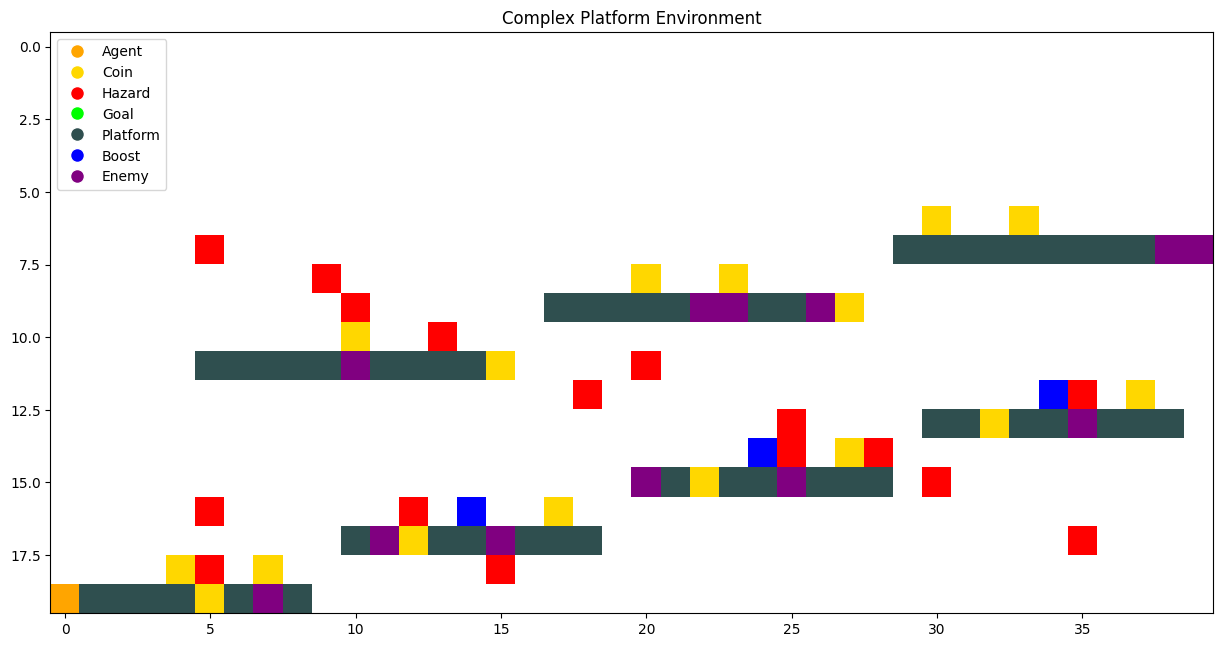

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import colors

class ComplexPlatformEnv:
    def __init__(self, grid_size=(20, 40), goal_reward=50, coin_reward=5, hazard_penalty=-10, fall_penalty=-20, enemy_penalty=-15, boost_reward=10):
        self.grid_size = grid_size
        self.goal_reward = goal_reward
        self.coin_reward = coin_reward
        self.hazard_penalty = hazard_penalty
        self.fall_penalty = fall_penalty
        self.enemy_penalty = enemy_penalty
        self.boost_reward = boost_reward
        self.gravity = 1
        self.jump_strength = 2
        self.platforms = [(19, 0, 8), (17, 10, 18), (15, 20, 28), (13, 30, 38), (11, 5, 15), (9, 17, 27), (7, 29, 39)]
        self.dynamic_hazards = [(18, 5), (16, 12), (14, 25), (12, 35)]
        self.boosts = [(16, 14), (14, 24), (12, 34)]
        self.reset()

    def reset(self):
        self.agent_pos = [19, 0]
        self.agent_velocity = 0
        self.coins = [(18, 4), (16, 14), (14, 24), (12, 34), (10, 10), (8, 20), (6, 30), (18, 7), (16, 17), (14, 27), (12, 37), (10, 13), (8, 23), (6, 33), (19, 5), (17, 12), (15, 22), (13, 32), (11, 15), (9, 27)]  # Place coins on top of platforms
        self.hazards = [(8, 9), (10, 13), (12, 18), (14, 28), (16, 5), (18, 15), (7, 5), (9, 10), (11, 20), (13, 25), (15, 30), (17, 35)]  # Static hazards on platforms
        self.dynamic_hazards = [(18, 5), (16, 12), (14, 25), (12, 35)]
        self.goal_position = (7, 39)
        self.enemies = self._place_enemies_on_platforms()
        self.done = False
        return self._get_state()

    def _place_enemies_on_platforms(self):
        enemies = []
        for platform in self.platforms:
            row, start_col, end_col = platform
            num_enemies = random.randint(1, 3)
            for _ in range(num_enemies):
                col = random.randint(start_col, end_col)
                enemies.append((row, col))
        return enemies

    def _get_state(self):
        state = (self.agent_pos[0], self.agent_pos[1], self.agent_velocity)
        return state

    def _apply_gravity(self):
        if not self._on_platform() and self.agent_pos[0] < self.grid_size[0] - 1:
            self.agent_velocity += self.gravity
            self.agent_pos[0] = min(self.agent_pos[0] + self.agent_velocity, self.grid_size[0] - 1)
        else:
            self.agent_velocity = 0

    def _on_platform(self):
        for platform in self.platforms:
            row, start_col, end_col = platform
            if self.agent_pos[0] == row and start_col <= self.agent_pos[1] <= end_col:
                return True
        return False

    def _move_hazards(self):
        for i, (row, col) in enumerate(self.dynamic_hazards):
            new_col = (col + 1) % self.grid_size[1]
            self.dynamic_hazards[i] = (row, new_col)

    def _move_enemies(self):
        for i, (row, col) in enumerate(self.enemies):
            direction = 1 if i % 2 == 0 else -1
            new_col = col + direction
            if new_col >= self.grid_size[1] or new_col < 0:
                new_col = col
            self.enemies[i] = (row, new_col)

    def step(self, action):
        if self.done:
            raise Exception("Game is over. Call reset() to start again.")
        if action == 0:  # Move left
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == 1:  # Move right
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.grid_size[1] - 1)
        elif action == 2:  # Jump (only if on platform)
            if self._on_platform():
                self.agent_velocity = -self.jump_strength
                self.agent_pos[0] = max(self.agent_pos[0] + self.agent_velocity, 0)

        self._apply_gravity()
        self._move_hazards()
        self._move_enemies()

        reward = 0
        if tuple(self.agent_pos) == self.goal_position:
            reward += self.goal_reward
            self.done = True
        elif tuple(self.agent_pos) in self.coins:
            reward += self.coin_reward
            self.coins.remove(tuple(self.agent_pos))  # Remove coin after collection
        elif tuple(self.agent_pos) in self.hazards or tuple(self.agent_pos) in self.dynamic_hazards:
            reward += self.hazard_penalty
        elif tuple(self.agent_pos) in self.enemies:
            reward += self.enemy_penalty
        elif tuple(self.agent_pos) in self.boosts:
            reward += self.boost_reward
            self.boosts.remove(tuple(self.agent_pos))  # Remove boost after collection
        elif self.agent_pos[0] == self.grid_size[0] - 1:  # If falling off the platform
            reward += self.fall_penalty
            self.done = True

        return self._get_state(), reward, self.done

    def render(self):
        grid = np.zeros(self.grid_size)
        for platform in self.platforms:
            row, start_col, end_col = platform
            grid[row, start_col:end_col + 1] = 1
        grid[self.goal_position] = 4
        for coin in self.coins:
            grid[coin] = 3
        for hazard in self.hazards:
            grid[hazard] = 2
        for d_hazard in self.dynamic_hazards:
            grid[d_hazard] = 2
        for enemy in self.enemies:
            grid[enemy] = 6
        for boost in self.boosts:
            grid[boost] = 5
        grid[tuple(self.agent_pos)] = 7

        cmap = colors.ListedColormap(['#ffffff', '#2f4f4f', '#ff0000', '#ffd700', '#00ff00', '#0000ff', '#800080', '#ffa500'])
        bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(grid, cmap=cmap, norm=norm)

        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffa500', markersize=10, label='Agent'),   # Agent
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffd700', markersize=10, label='Coin'),    # Coin
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff0000', markersize=10, label='Hazard'),  # Hazard
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#00ff00', markersize=10, label='Goal'),    # Goal
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2f4f4f', markersize=10, label='Platform'),# Platform
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#0000ff', markersize=10, label='Boost'),   # Boost
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#800080', markersize=10, label='Enemy'),   # Enemy
        ]
        ax.legend(handles=legend_elements, loc='upper left')
        plt.grid(False)
        plt.title('Complex Platform Environment')
        plt.show()

env = ComplexPlatformEnv()
state = env.reset()
env.render()

Episode 100: Total Reward: -80
Episode 200: Total Reward: -65
Episode 300: Total Reward: -20
Episode 400: Total Reward: -20
Episode 500: Total Reward: -20
Episode 600: Total Reward: -50
Episode 700: Total Reward: -20
Episode 800: Total Reward: -20
Episode 900: Total Reward: -20
Episode 1000: Total Reward: -20
Episode 1100: Total Reward: -20
Episode 1200: Total Reward: -20
Episode 1300: Total Reward: -35
Episode 1400: Total Reward: -20
Episode 1500: Total Reward: -20
Episode 1600: Total Reward: -35
Episode 1700: Total Reward: -20
Episode 1800: Total Reward: -20
Episode 1900: Total Reward: -20
Episode 2000: Total Reward: -20
Episode 2100: Total Reward: -20
Episode 2200: Total Reward: -20
Episode 2300: Total Reward: -20
Episode 2400: Total Reward: -20
Episode 2500: Total Reward: -20
Episode 2600: Total Reward: -20
Episode 2700: Total Reward: -20
Episode 2800: Total Reward: -20
Episode 2900: Total Reward: -20
Episode 3000: Total Reward: -35
Episode 3100: Total Reward: -20
Episode 3200: Tot

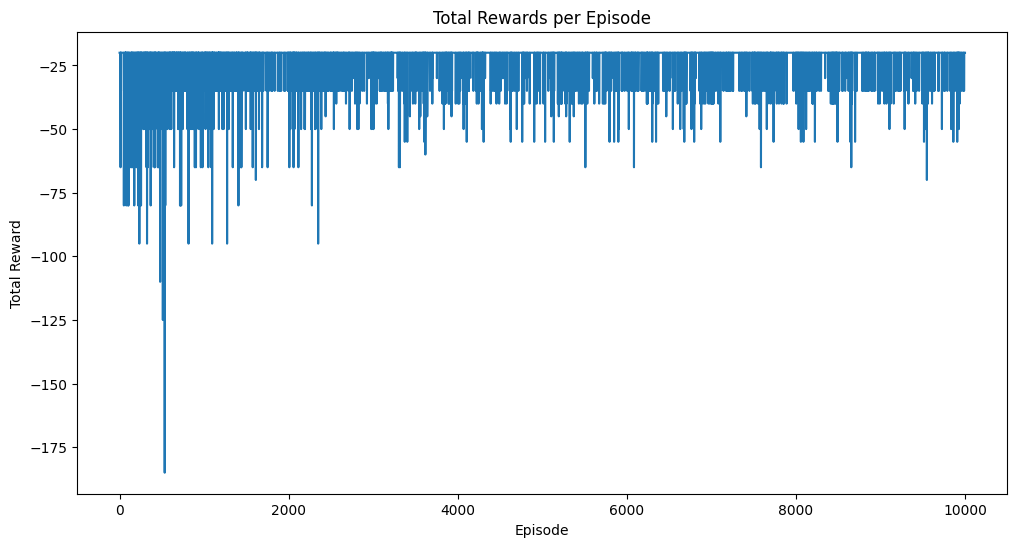

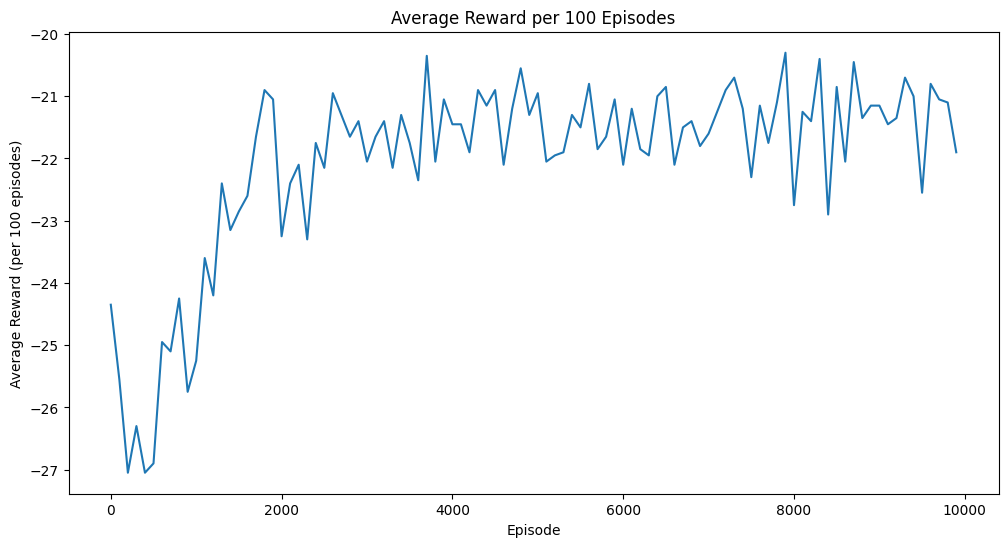

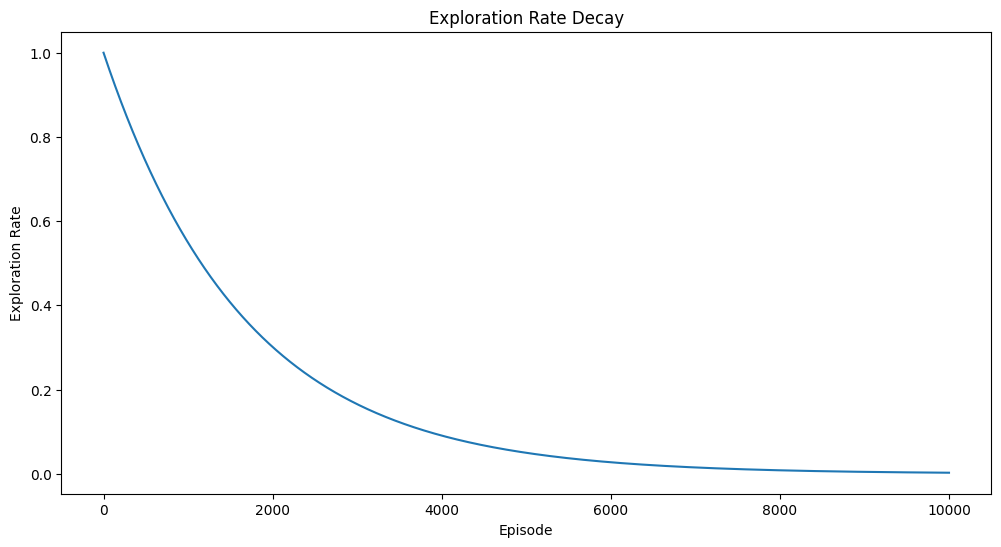

Final Total Reward: -20
Average Reward: -22.0475


In [ ]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

class QLearningAgent:
    def __init__(self, env, learning_rate=0.02, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.9994, min_exploration_rate=0.001):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table = defaultdict(lambda: np.zeros(3))  # Initialize Q-table with zeros for 3 actions
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2])  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)
            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Rewards per Episode')
        plt.show()

        avg_rewards = [np.mean(self.rewards_per_episode[i:i+100]) for i in range(0, len(self.rewards_per_episode), 100)]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Average Reward (per 100 episodes)')
        plt.title('Average Reward per 100 Episodes')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel('Episode')
        plt.ylabel('Exploration Rate')
        plt.title('Exploration Rate Decay')
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Average Reward: {average_reward}")

env = ComplexPlatformEnv()
agent = QLearningAgent(env)
agent.train(episodes=10000)
agent.plot_performance()

Episode 100: Total Reward: -20
Episode 200: Total Reward: -20
Episode 300: Total Reward: -20
Episode 400: Total Reward: -20
Episode 500: Total Reward: -20
Episode 600: Total Reward: -35
Episode 700: Total Reward: -20
Episode 800: Total Reward: -20
Episode 900: Total Reward: -20
Episode 1000: Total Reward: -35
Episode 1100: Total Reward: -20
Episode 1200: Total Reward: -35
Episode 1300: Total Reward: -20
Episode 1400: Total Reward: -20
Episode 1500: Total Reward: -20
Episode 1600: Total Reward: -35
Episode 1700: Total Reward: -20
Episode 1800: Total Reward: -35
Episode 1900: Total Reward: -20
Episode 2000: Total Reward: -20
Episode 2100: Total Reward: -20
Episode 2200: Total Reward: -20
Episode 2300: Total Reward: -20
Episode 2400: Total Reward: -20
Episode 2500: Total Reward: -20
Episode 2600: Total Reward: -20
Episode 2700: Total Reward: -20
Episode 2800: Total Reward: -20
Episode 2900: Total Reward: -20
Episode 3000: Total Reward: -20
Episode 3100: Total Reward: -20
Episode 3200: Tot

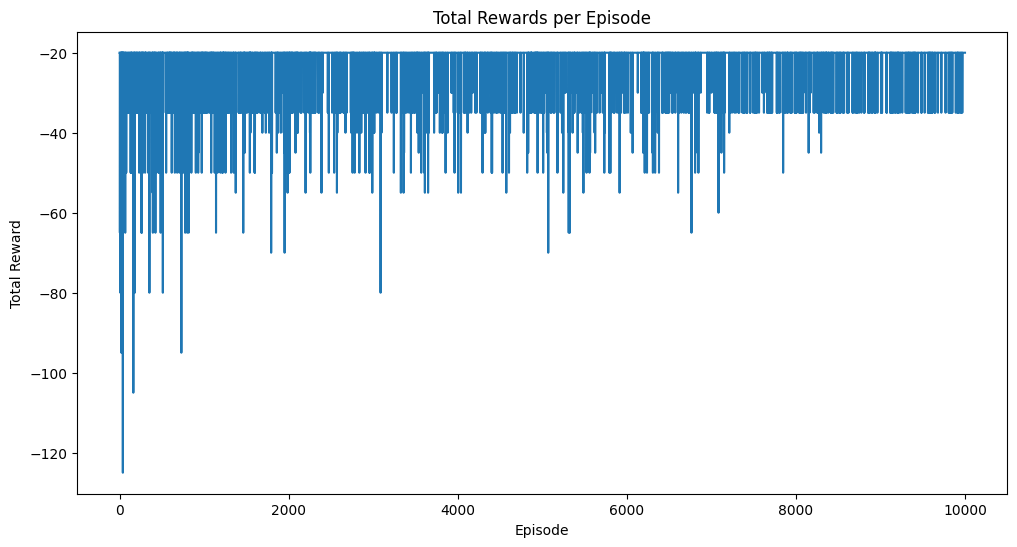

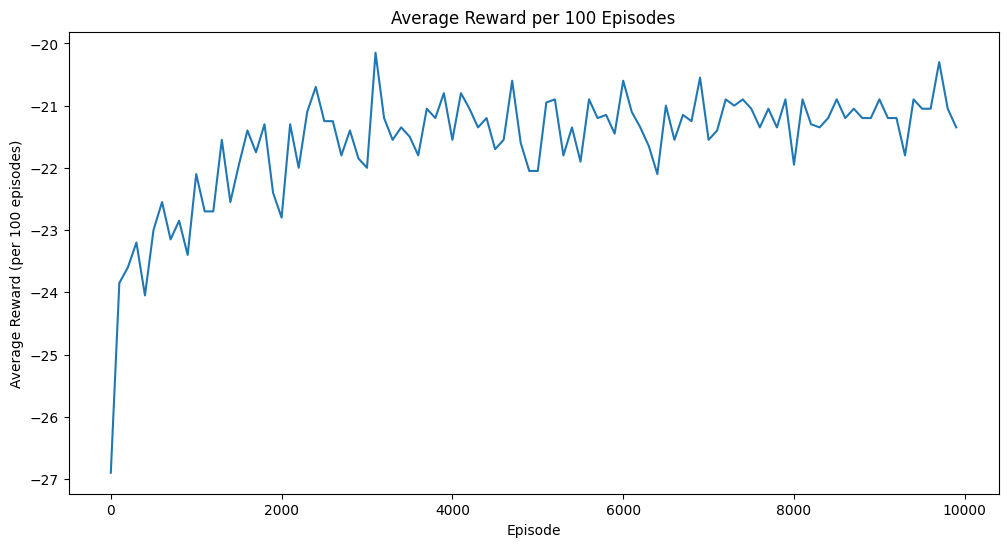

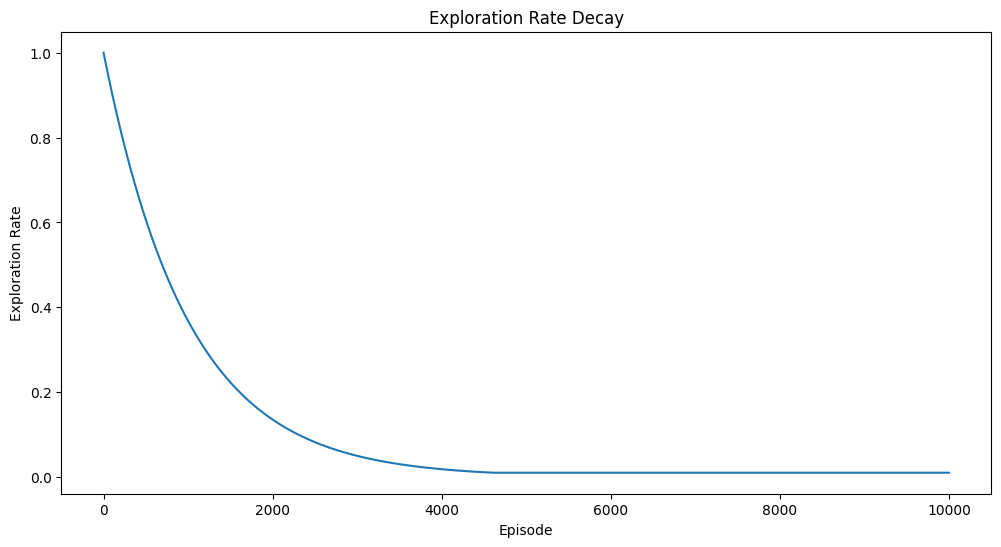

Final Total Reward: -20
Average Reward: -21.589


In [ ]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

class DoubleQLearningAgent:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(3))  # Initialize Q-table 1 with zeros for 3 actions
        self.q_table2 = defaultdict(lambda: np.zeros(3))  # Initialize Q-table 2 with zeros for 3 actions
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2])  # Explore
        else:
            q_values = self.q_table1[state] + self.q_table2[state]
            return np.argmax(q_values)  # Exploit

    def update_q_tables(self, state, action, reward, next_state):
        if random.uniform(0, 1) < 0.5:
            best_next_action = np.argmax(self.q_table1[next_state])
            td_target = reward + self.discount_factor * self.q_table2[next_state][best_next_action]
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(self.q_table2[next_state])
            td_target = reward + self.discount_factor * self.q_table1[next_state][best_next_action]
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Rewards per Episode')
        plt.show()

        avg_rewards = [np.mean(self.rewards_per_episode[i:i+100]) for i in range(0, len(self.rewards_per_episode), 100)]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Average Reward (per 100 episodes)')
        plt.title('Average Reward per 100 Episodes')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel('Episode')
        plt.ylabel('Exploration Rate')
        plt.title('Exploration Rate Decay')
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Average Reward: {average_reward}")

env = ComplexPlatformEnv()
agent = DoubleQLearningAgent(env)
agent.train(episodes=10000)
agent.plot_performance()

Episode 1000: Total Reward: -20
Episode 2000: Total Reward: -20
Episode 3000: Total Reward: -20
Episode 4000: Total Reward: -20
Episode 5000: Total Reward: -20
Episode 6000: Total Reward: -20
Episode 7000: Total Reward: -20
Episode 8000: Total Reward: -20
Episode 9000: Total Reward: -20
Episode 10000: Total Reward: -20


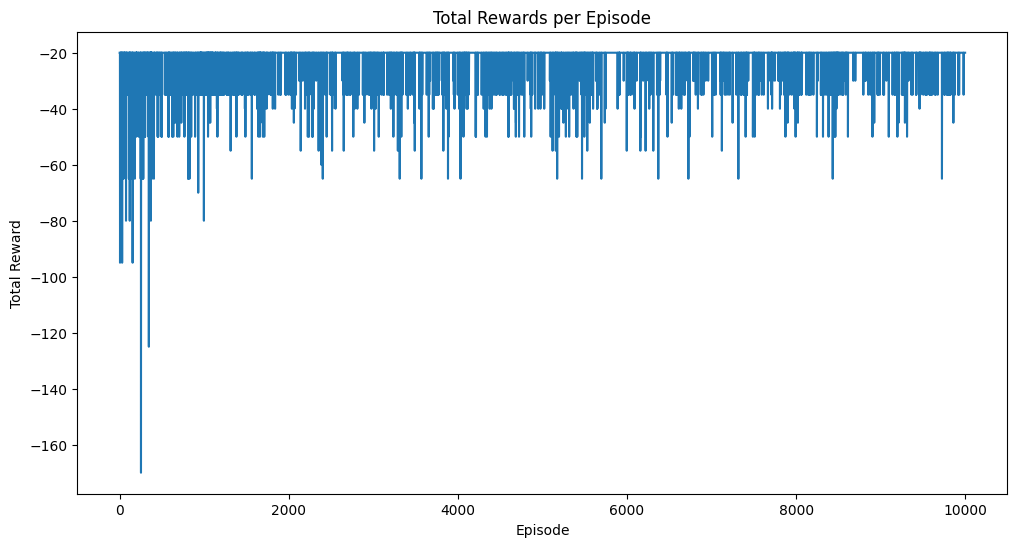

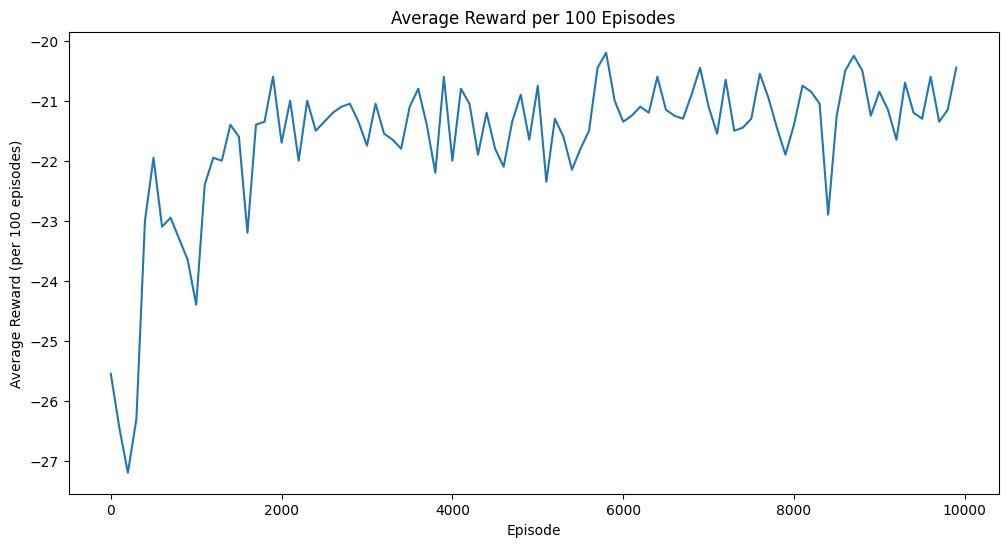

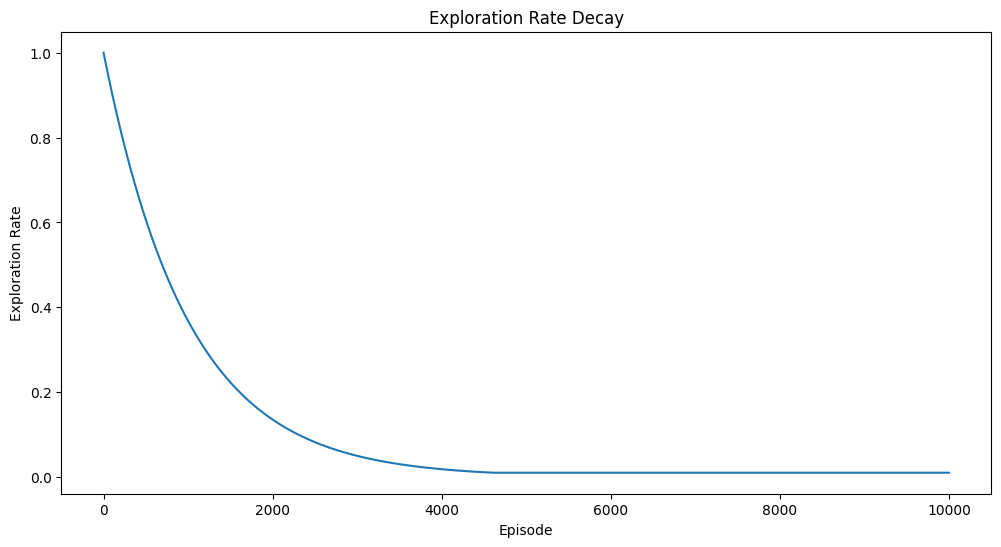

Final Total Reward: -20
Average Reward: -21.628


In [ ]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

class TripleQLearningAgent:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(3))  # Initialize Q-table 1 with zeros for 3 actions
        self.q_table2 = defaultdict(lambda: np.zeros(3))  # Initialize Q-table 2 with zeros for 3 actions
        self.q_table3 = defaultdict(lambda: np.zeros(3))  # Initialize Q-table 3 with zeros for 3 actions
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2])  # Explore
        else:
            q_values = self.q_table1[state] + self.q_table2[state] + self.q_table3[state]
            return np.argmax(q_values)  # Exploit

    def update_q_tables(self, state, action, reward, next_state):
        choice = random.uniform(0, 1)
        if choice < 1/3:
            best_next_action = np.argmax(self.q_table1[next_state])
            td_target = reward + self.discount_factor * min(self.q_table2[next_state][best_next_action], self.q_table3[next_state][best_next_action])
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        elif choice < 2/3:
            best_next_action = np.argmax(self.q_table2[next_state])
            td_target = reward + self.discount_factor * min(self.q_table1[next_state][best_next_action], self.q_table3[next_state][best_next_action])
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(self.q_table3[next_state])
            td_target = reward + self.discount_factor * min(self.q_table1[next_state][best_next_action], self.q_table2[next_state][best_next_action])
            td_error = td_target - self.q_table3[state][action]
            self.q_table3[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Rewards per Episode')
        plt.show()

        avg_rewards = [np.mean(self.rewards_per_episode[i:i+100]) for i in range(0, len(self.rewards_per_episode), 100)]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Average Reward (per 100 episodes)')
        plt.title('Average Reward per 100 Episodes')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel('Episode')
        plt.ylabel('Exploration Rate')
        plt.title('Exploration Rate Decay')
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Average Reward: {average_reward}")

env = ComplexPlatformEnv()
agent = TripleQLearningAgent(env)
agent.train(episodes=10000)
agent.plot_performance()

Episode 100: Total Reward: -50
Episode 200: Total Reward: -35
Episode 300: Total Reward: -20
Episode 400: Total Reward: -35
Episode 500: Total Reward: -20
Episode 600: Total Reward: -35
Episode 700: Total Reward: -20
Episode 800: Total Reward: -20
Episode 900: Total Reward: -20
Episode 1000: Total Reward: -20
Episode 1100: Total Reward: -20
Episode 1200: Total Reward: -20
Episode 1300: Total Reward: -20
Episode 1400: Total Reward: -20
Episode 1500: Total Reward: -20
Episode 1600: Total Reward: -20
Episode 1700: Total Reward: -20
Episode 1800: Total Reward: -20
Episode 1900: Total Reward: -20
Episode 2000: Total Reward: -20
Episode 2100: Total Reward: -20
Episode 2200: Total Reward: -20
Episode 2300: Total Reward: -20
Episode 2400: Total Reward: -20
Episode 2500: Total Reward: -20
Episode 2600: Total Reward: -20
Episode 2700: Total Reward: -20
Episode 2800: Total Reward: -35
Episode 2900: Total Reward: -20
Episode 3000: Total Reward: -20
Episode 3100: Total Reward: -20
Episode 3200: Tot

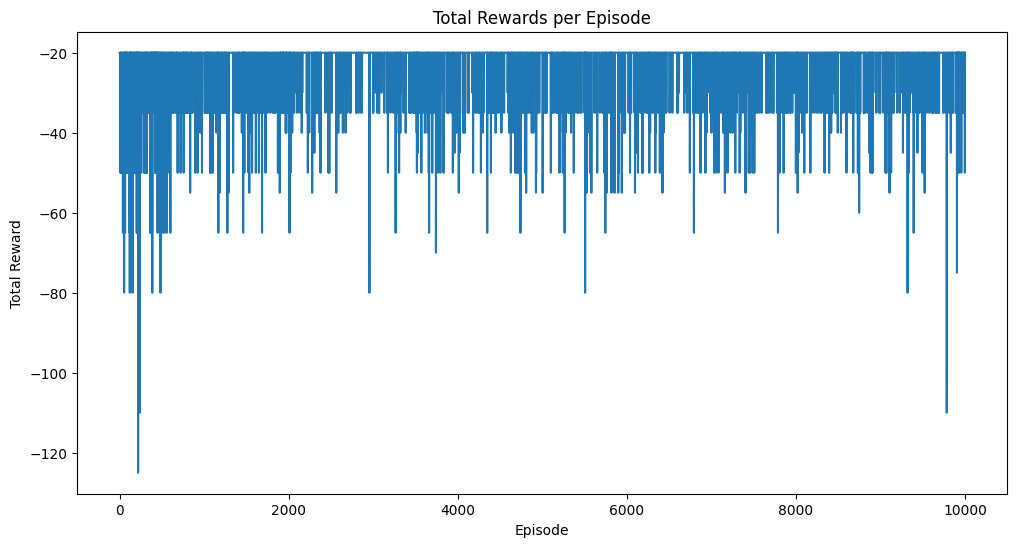

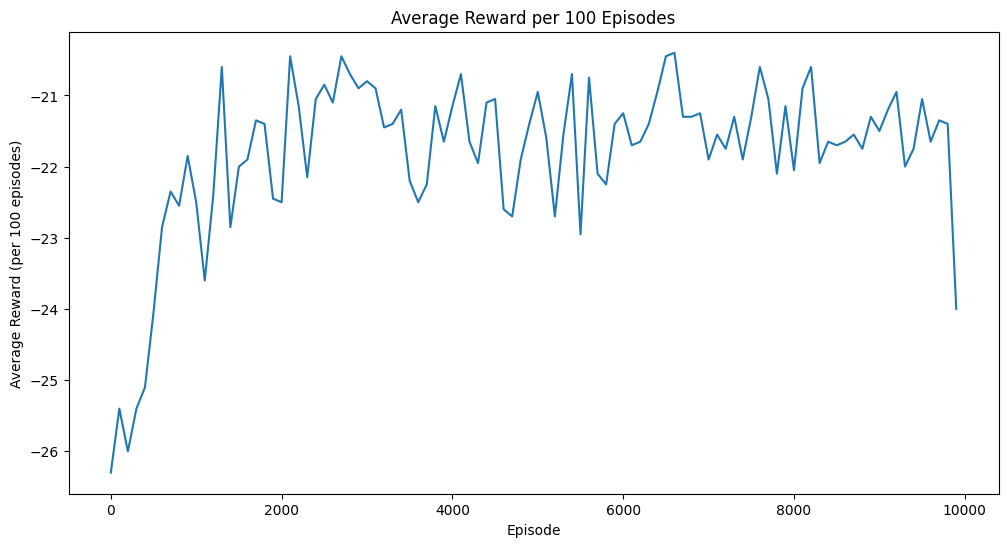

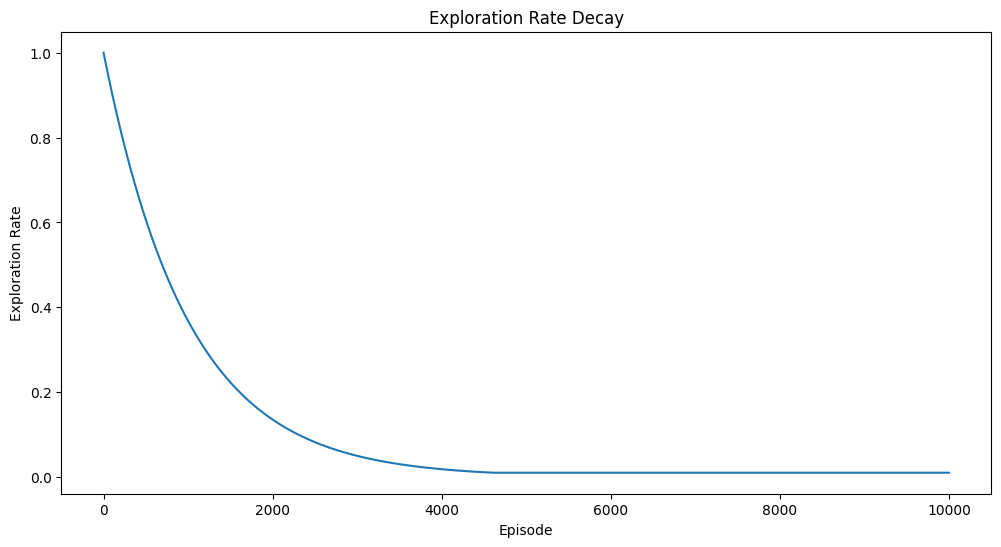

Final Total Reward: -20
Average Reward: -21.8105


In [ ]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

class QuadrupleQLearningAgent:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(3))  # Initialize Q-table 1 with zeros for 3 actions
        self.q_table2 = defaultdict(lambda: np.zeros(3))  # Initialize Q-table 2 with zeros for 3 actions
        self.q_table3 = defaultdict(lambda: np.zeros(3))  # Initialize Q-table 3 with zeros for 3 actions
        self.q_table4 = defaultdict(lambda: np.zeros(3))  # Initialize Q-table 4 with zeros for 3 actions
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2])  # Explore
        else:
            q_values = self.q_table1[state] + self.q_table2[state] + self.q_table3[state] + self.q_table4[state]
            return np.argmax(q_values)  # Exploit

    def update_q_tables(self, state, action, reward, next_state):
        choice = random.uniform(0, 1)
        if choice < 0.25:
            best_next_action = np.argmax(self.q_table1[next_state])
            td_target = reward + self.discount_factor * min(self.q_table2[next_state][best_next_action], self.q_table3[next_state][best_next_action], self.q_table4[next_state][best_next_action])
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        elif choice < 0.5:
            best_next_action = np.argmax(self.q_table2[next_state])
            td_target = reward + self.discount_factor * min(self.q_table1[next_state][best_next_action], self.q_table3[next_state][best_next_action], self.q_table4[next_state][best_next_action])
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error
        elif choice < 0.75:
            best_next_action = np.argmax(self.q_table3[next_state])
            td_target = reward + self.discount_factor * min(self.q_table1[next_state][best_next_action], self.q_table2[next_state][best_next_action], self.q_table4[next_state][best_next_action])
            td_error = td_target - self.q_table3[state][action]
            self.q_table3[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(self.q_table4[next_state])
            td_target = reward + self.discount_factor * min(self.q_table1[next_state][best_next_action], self.q_table2[next_state][best_next_action], self.q_table3[next_state][best_next_action])
            td_error = td_target - self.q_table4[state][action]
            self.q_table4[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Rewards per Episode')
        plt.show()

        avg_rewards = [np.mean(self.rewards_per_episode[i:i+100]) for i in range(0, len(self.rewards_per_episode), 100)]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Average Reward (per 100 episodes)')
        plt.title('Average Reward per 100 Episodes')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel('Episode')
        plt.ylabel('Exploration Rate')
        plt.title('Exploration Rate Decay')
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Average Reward: {average_reward}")

env = ComplexPlatformEnv()
agent = QuadrupleQLearningAgent(env)
agent.train(episodes=10000)
agent.plot_performance()

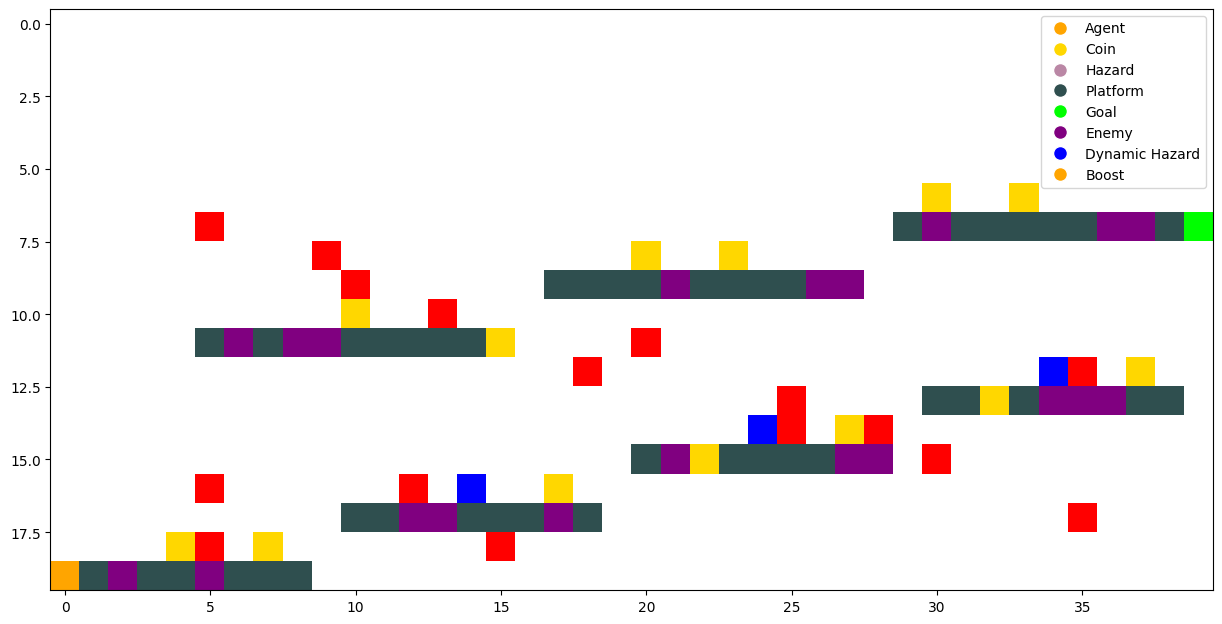

In [ ]:
class ComplexPlatformEnv:
    def __init__(self, grid_size=(20, 40), goal_reward=500, coin_reward=5, hazard_penalty=-10, fall_penalty=-30, enemy_penalty=-15, boost_reward=10, survival_reward=-1):
        self.grid_size = grid_size
        self.goal_reward = goal_reward
        self.coin_reward = coin_reward
        self.hazard_penalty = hazard_penalty
        self.fall_penalty = fall_penalty
        self.enemy_penalty = enemy_penalty
        self.turn_reward = survival_reward
        self.boost_reward = boost_reward
        self.gravity = 1
        self.jump_strength = 4
        self.platforms = [(19, 0, 8), (17, 10, 18), (15, 20, 28), (13, 30, 38), (11, 5, 15), (9, 17, 27), (7, 29, 39)]
        self.dynamic_hazards = [(18, 5), (16, 12), (14, 25), (12, 35)]
        self.boosts = [(16, 14), (14, 24), (12, 34)]
        self.reset()

    def reset(self):
        self.agent_pos = [19, 0]
        self.agent_velocity = 0
        self.coins = [(18, 4), (16, 14), (14, 24), (12, 34), (10, 10), (8, 20), (6, 30), (18, 7), (16, 17), (14, 27), (12, 37), (10, 13), (8, 23), (6, 33), (19, 5), (17, 12), (15, 22), (13, 32), (11, 15), (9, 27)]
        self.hazards = [(8, 9), (10, 13), (12, 18), (14, 28), (16, 5), (18, 15), (7, 5), (9, 10), (11, 20), (13, 25), (15, 30), (17, 35)]
        self.dynamic_hazards = [(18, 5), (16, 12), (14, 25), (12, 35)]
        self.goal_position = (7, 39)
        self.enemies = self._place_enemies_on_platforms()
        self.done = False
        return self._get_state()

    def _place_enemies_on_platforms(self):
        enemies = []
        for platform in self.platforms:
            row, start_col, end_col = platform
            num_enemies = random.randint(1, 3)
            for _ in range(num_enemies):
                col = random.randint(start_col, end_col)
                enemies.append((row, col))
        return enemies

    def _get_state(self):
        state = (self.agent_pos[0], self.agent_pos[1], self.agent_velocity)
        return state

    def _apply_gravity(self):
        if not self._on_platform(self.agent_pos) and self.agent_pos[0] < self.grid_size[0] - 1:
            self.agent_velocity += self.gravity
            base = min(self.agent_pos[0] + self.agent_velocity, self.grid_size[0] - 1)
            for i in range(self.agent_pos[0], base):
                if self._on_platform(pos=[i, self.agent_pos[1]]):
                    base = i
                    break
            self.agent_pos[0] = base
        else:
            self.agent_velocity = 0

    def _on_platform(self, pos):
        for platform in self.platforms:
            row, start_col, end_col = platform
            if pos[0] == row and start_col <= pos[1] <= end_col:
                return True
        return False

    def _move_hazards(self):
        for i, (row, col) in enumerate(self.dynamic_hazards):
            new_col = (col + 1) % self.grid_size[1]
            self.dynamic_hazards[i] = (row, new_col)

    def _move_enemies(self):
        for i, (row, col) in enumerate(self.enemies):
            direction = 1 if i % 2 == 0 else -1
            new_col = col + direction
            if new_col >= self.grid_size[1] or new_col < 0:
                new_col = col
            self.enemies[i] = (row, new_col)

    def _kill_enemies(self):
        surrounding_positions = [
            (self.agent_pos[0] + dy, self.agent_pos[1] + dx)
            for dy in [-1, 0, 1]
            for dx in [-1, 0, 1]
            if (dy != 0 or dx != 0)  # Exclude the agent's own position
        ]
        killed_enemies = []
        for pos in surrounding_positions:
            if pos in self.enemies:
                killed_enemies.append(pos)
        for enemy in killed_enemies:
            self.enemies.remove(enemy)
        return len(killed_enemies) * self.enemy_penalty  # Reward for killing enemies

    def step(self, action):
        if self.done:
            raise Exception("Game is over. Call reset() to start again.")
        reward = self.turn_reward
        if action == 0:  # Move left
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == 1:  # Move right
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.grid_size[1] - 1)
        elif action == 2:  # Jump (only if on platform)
            if self._on_platform(self.agent_pos):
                self.agent_velocity = -self.jump_strength
                self.agent_pos[0] = max(self.agent_pos[0] + self.agent_velocity, 0)
        elif action == 3:  # Kill enemies around
            reward += self._kill_enemies()

        self._apply_gravity()
        self._move_hazards()
        self._move_enemies()

        if tuple(self.agent_pos) == self.goal_position:
            reward += self.goal_reward
            self.done = True
        elif tuple(self.agent_pos) in self.coins:
            reward += self.coin_reward
            self.coins.remove(tuple(self.agent_pos))
        elif tuple(self.agent_pos) in self.hazards or tuple(self.agent_pos) in self.dynamic_hazards:
            reward += self.hazard_penalty
        elif tuple(self.agent_pos) in self.enemies:
            reward += self.enemy_penalty
        elif tuple(self.agent_pos) in self.boosts:
            reward += self.boost_reward
            self.boosts.remove(tuple(self.agent_pos))
        elif self.agent_pos[0] == self.grid_size[0] - 1:
            reward += self.fall_penalty
            self.done = True

        return self._get_state(), reward, self.done

    def render(self):
        grid = np.zeros(self.grid_size)

        for platform in self.platforms:
            row, start_col, end_col = platform
            grid[row, start_col:end_col + 1] = 1
        for coin in self.coins:
            grid[coin] = 3  # Coins
        for hazard in self.hazards:
            grid[hazard] = 2  # Static hazards
        for d_hazard in self.dynamic_hazards:
            grid[d_hazard] = 2  # Dynamic hazards
        for enemy in self.enemies:
            grid[enemy] = 6  # Enemies
        for boost in self.boosts:
            grid[boost] = 5  # Boosts
        grid[self.goal_position] = 4  # Goal
        grid[tuple(self.agent_pos)] = 7  # Agent

        cmap = colors.ListedColormap(['#ffffff', '#2f4f4f', '#ff0000', '#ffd700', '#00ff00', '#0000ff', '#800080', '#ffa500'])
        bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(grid, cmap=cmap, norm=norm)

        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffa500', markersize=10, label='Agent'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffd700', markersize=10, label='Coin'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#BA87A5', markersize=10, label='Hazard'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2f4f4f', markersize=10, label='Platform'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#00ff00', markersize=10, label='Goal'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#800080', markersize=10, label='Enemy'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#0000ff', markersize=10, label='Dynamic Hazard'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffa500', markersize=10, label='Boost'),
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.show()

env = ComplexPlatformEnv()
state = env.reset()
env.render()


Episode 1000: Total Reward: -53
Episode 2000: Total Reward: -31
Episode 3000: Total Reward: -48
Episode 4000: Total Reward: -53
Episode 5000: Total Reward: -41
Episode 6000: Total Reward: -31
Episode 7000: Total Reward: -64
Episode 8000: Total Reward: -38
Episode 9000: Total Reward: -38
Episode 10000: Total Reward: -78
Episode 11000: Total Reward: -48
Episode 12000: Total Reward: -46
Episode 13000: Total Reward: -57
Episode 14000: Total Reward: -31
Episode 15000: Total Reward: -34
Episode 16000: Total Reward: -38
Episode 17000: Total Reward: -48
Episode 18000: Total Reward: 466
Episode 19000: Total Reward: 469
Episode 20000: Total Reward: -34
Episode 21000: Total Reward: 473
Episode 22000: Total Reward: 456
Episode 23000: Total Reward: -34
Episode 24000: Total Reward: -41
Episode 25000: Total Reward: -38
Episode 26000: Total Reward: 449
Episode 27000: Total Reward: 468
Episode 28000: Total Reward: -41
Episode 29000: Total Reward: -31
Episode 30000: Total Reward: 472
Episode 31000: Tota

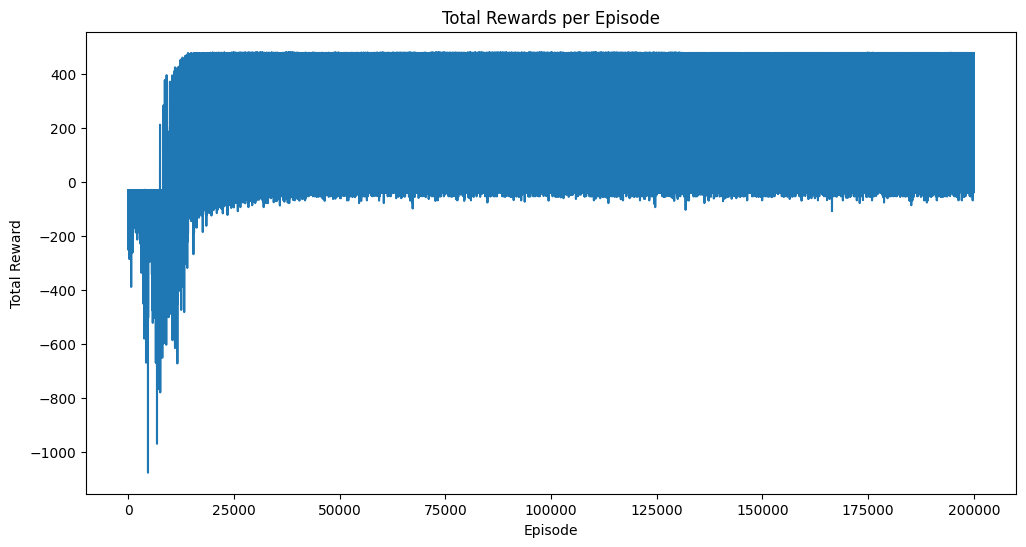

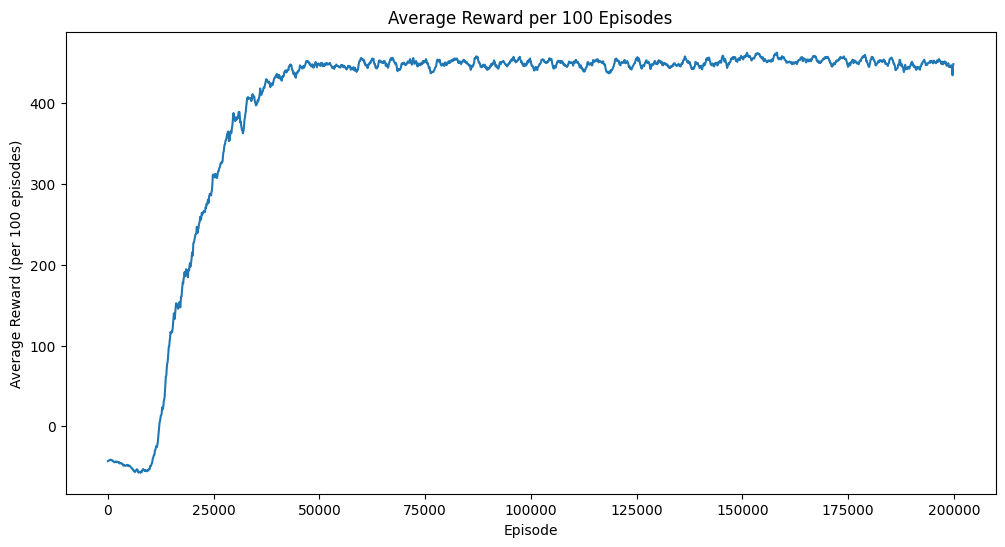

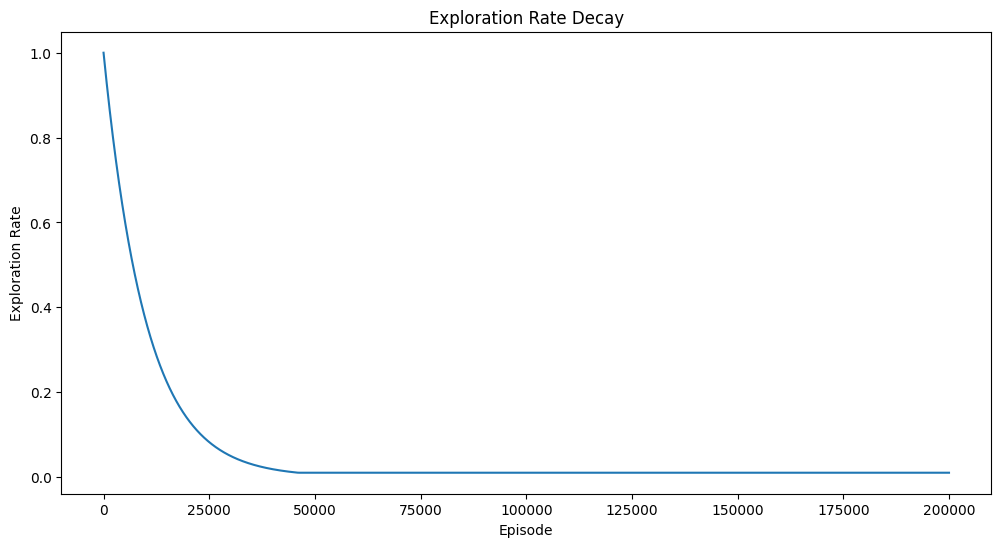

Final Total Reward: 469
Average Reward: 396.011925


In [ ]:
from collections import defaultdict
import time

class QLearningAgent:
    def __init__(self, env, learning_rate=0.08, discount_factor=0.90, exploration_rate=1.0, exploration_decay=0.9999, min_exploration_rate=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table = defaultdict(lambda: np.zeros(4))  # Initialize Q-table with zeros for 4 actions
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Rewards per Episode')
        plt.show()

        avg_rewards = [np.mean(self.rewards_per_episode[i:i+1000]) for i in range(0, len(self.rewards_per_episode), 100)]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Average Reward (per 100 episodes)')
        plt.title('Average Reward per 100 Episodes')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel('Episode')
        plt.ylabel('Exploration Rate')
        plt.title('Exploration Rate Decay')
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Average Reward: {average_reward}")

env = ComplexPlatformEnv()
agent = QLearningAgent(env)
agent.train(episodes=200000)
agent.plot_performance()

Episode 1000: Total Reward: -31
Episode 2000: Total Reward: -31
Episode 3000: Total Reward: -63
Episode 4000: Total Reward: -31
Episode 5000: Total Reward: -41
Episode 6000: Total Reward: -38
Episode 7000: Total Reward: -31
Episode 8000: Total Reward: -31
Episode 9000: Total Reward: -38
Episode 10000: Total Reward: -97
Episode 11000: Total Reward: -112
Episode 12000: Total Reward: 134
Episode 13000: Total Reward: -48
Episode 14000: Total Reward: -38
Episode 15000: Total Reward: 343
Episode 16000: Total Reward: -77
Episode 17000: Total Reward: -138
Episode 18000: Total Reward: -77
Episode 19000: Total Reward: 468
Episode 20000: Total Reward: -34
Episode 21000: Total Reward: -53
Episode 22000: Total Reward: 469
Episode 23000: Total Reward: 473
Episode 24000: Total Reward: -45
Episode 25000: Total Reward: 461
Episode 26000: Total Reward: 475
Episode 27000: Total Reward: -38
Episode 28000: Total Reward: -66
Episode 29000: Total Reward: 471
Episode 30000: Total Reward: 477
Episode 31000: To

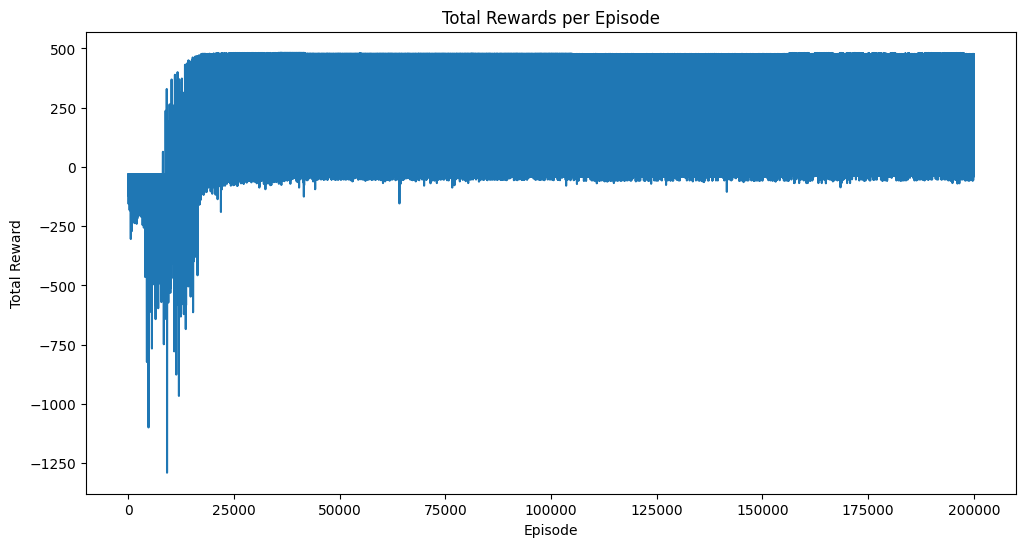

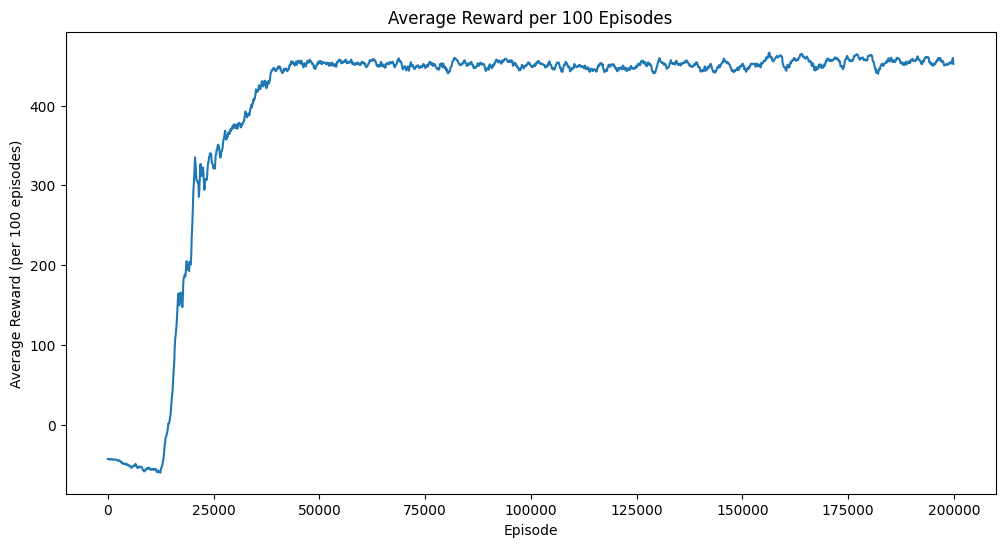

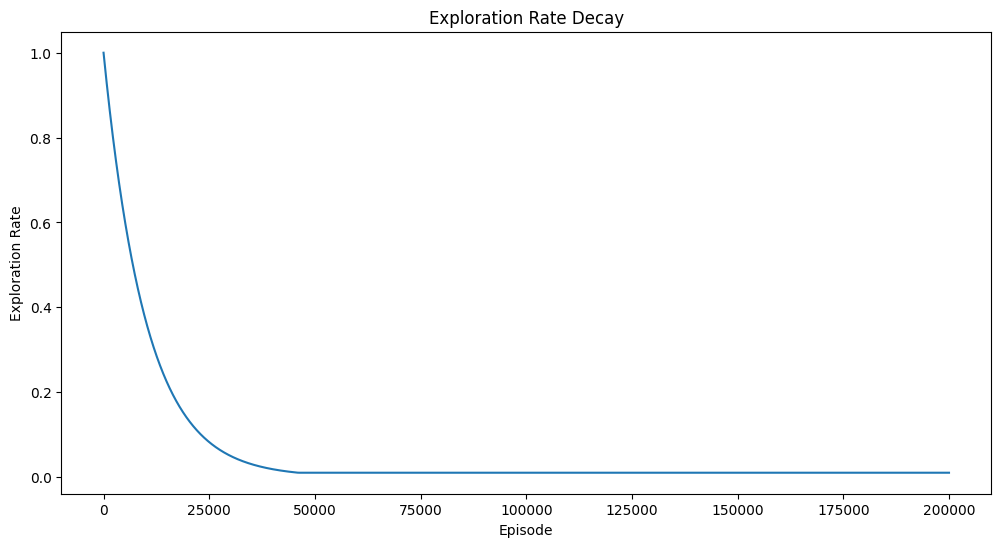

Final Total Reward: 476
Average Reward: 397.865155


In [ ]:
class DoubleQLearningAgent:
    def __init__(self, env, learning_rate=0.08, discount_factor=0.90, exploration_rate=1.0, exploration_decay=0.9999, min_exploration_rate=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(4))
        self.q_table2 = defaultdict(lambda: np.zeros(4))
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])
        else:
            q_values = self.q_table1[state] + self.q_table2[state]
            return np.argmax(q_values)

    def update_q_tables(self, state, action, reward, next_state):
        if random.random() < 0.5:
            best_next_action = np.argmax(self.q_table2[next_state])
            td_target = reward + self.discount_factor * self.q_table2[next_state][best_next_action]
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(self.q_table1[next_state])
            td_target = reward + self.discount_factor * self.q_table1[next_state][best_next_action]
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Rewards per Episode')
        plt.show()

        avg_rewards = [np.mean(self.rewards_per_episode[i:i+1000]) for i in range(0, len(self.rewards_per_episode), 100)]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Average Reward (per 100 episodes)')
        plt.title('Average Reward per 100 Episodes')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel('Episode')
        plt.ylabel('Exploration Rate')
        plt.title('Exploration Rate Decay')
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Average Reward: {average_reward}")

env = ComplexPlatformEnv()
agent = DoubleQLearningAgent(env)
agent.train(episodes=200000)
agent.plot_performance()

Episode 1000: Total Reward: -48
Episode 2000: Total Reward: -38
Episode 3000: Total Reward: -31
Episode 4000: Total Reward: -54
Episode 5000: Total Reward: -38
Episode 6000: Total Reward: -38
Episode 7000: Total Reward: -34
Episode 8000: Total Reward: -41
Episode 9000: Total Reward: -31
Episode 10000: Total Reward: -31
Episode 11000: Total Reward: -38
Episode 12000: Total Reward: -84
Episode 13000: Total Reward: -56
Episode 14000: Total Reward: -42
Episode 15000: Total Reward: -31
Episode 16000: Total Reward: -31
Episode 17000: Total Reward: 339
Episode 18000: Total Reward: -46
Episode 19000: Total Reward: 369
Episode 20000: Total Reward: -48
Episode 21000: Total Reward: 471
Episode 22000: Total Reward: -41
Episode 23000: Total Reward: -77
Episode 24000: Total Reward: 468
Episode 25000: Total Reward: -46
Episode 26000: Total Reward: 474
Episode 27000: Total Reward: -31
Episode 28000: Total Reward: 473
Episode 29000: Total Reward: -34
Episode 30000: Total Reward: 432
Episode 31000: Tota

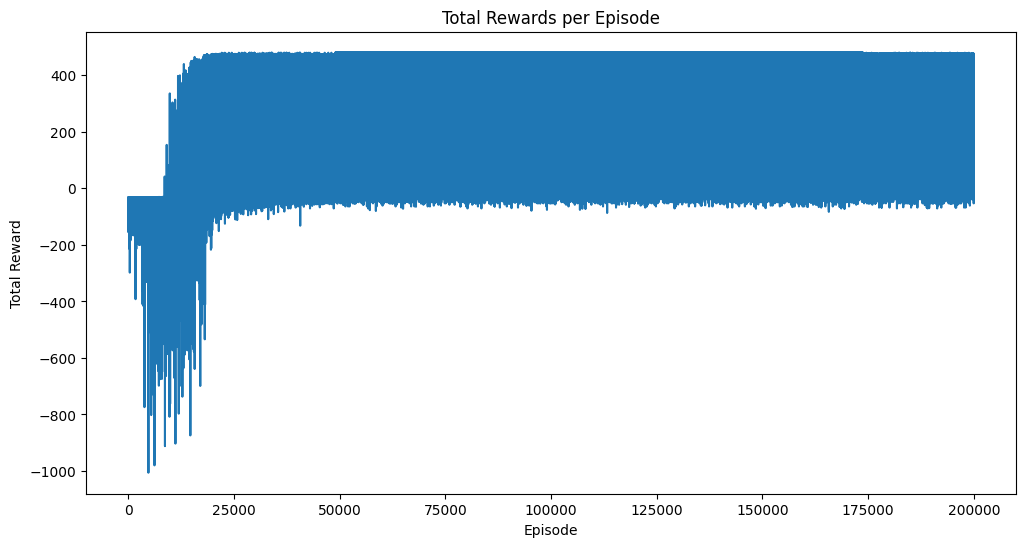

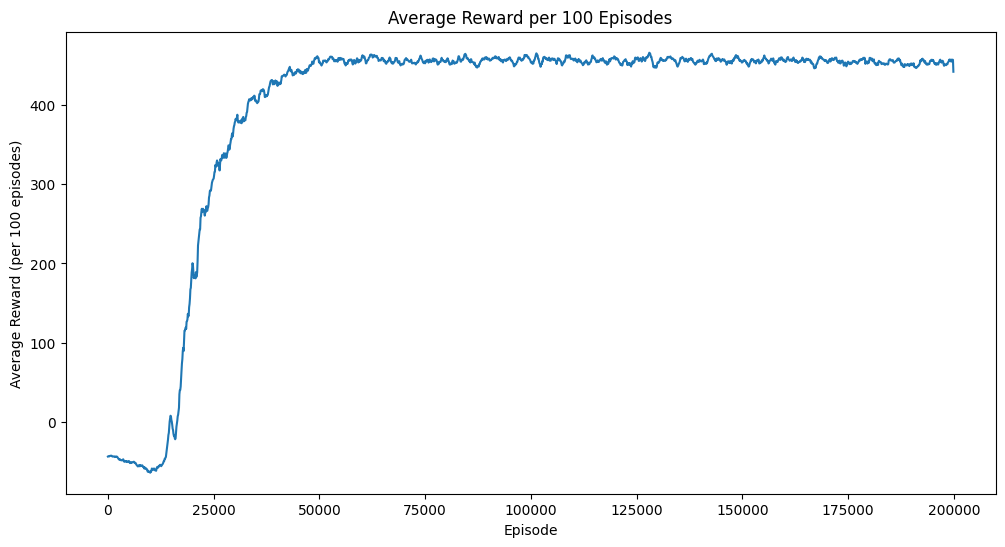

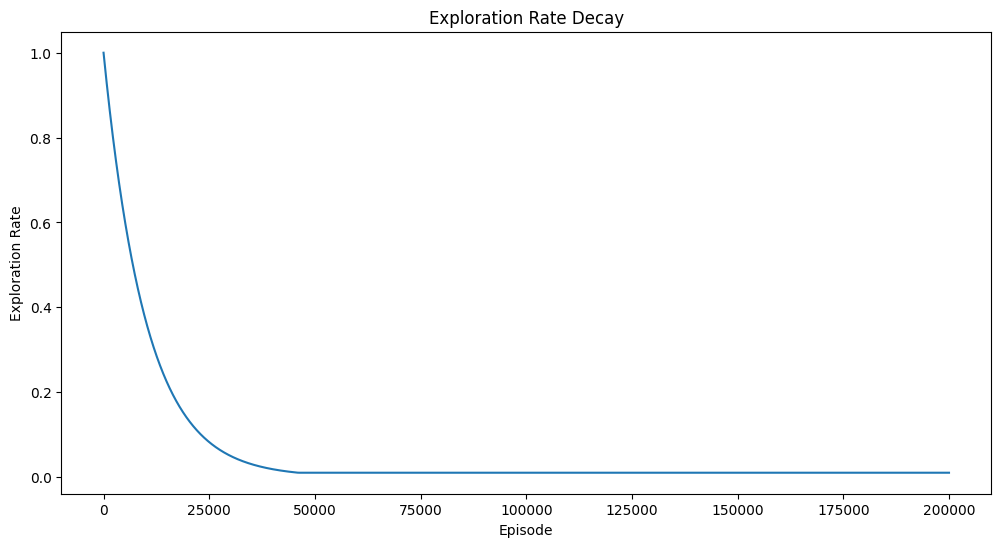

Final Total Reward: 476
Average Reward: 395.252725


In [ ]:
class TripleQLearningAgent:
    def __init__(self, env, learning_rate=0.08, discount_factor=0.90, exploration_rate=1.0, exploration_decay=0.9999, min_exploration_rate=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(4))
        self.q_table2 = defaultdict(lambda: np.zeros(4))
        self.q_table3 = defaultdict(lambda: np.zeros(4))
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])
        else:
            q_values = self.q_table1[state] + self.q_table2[state] + self.q_table3[state]
            return np.argmax(q_values)

    def update_q_tables(self, state, action, reward, next_state):
        update_choice = random.randint(1, 3)
        if update_choice == 1:
            best_next_action = np.argmax(self.q_table2[next_state] + self.q_table3[next_state])
            td_target = reward + self.discount_factor * self.q_table2[next_state][best_next_action]
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        elif update_choice == 2:
            best_next_action = np.argmax(self.q_table1[next_state] + self.q_table3[next_state])
            td_target = reward + self.discount_factor * self.q_table1[next_state][best_next_action]
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(self.q_table1[next_state] + self.q_table2[next_state])
            td_target = reward + self.discount_factor * self.q_table1[next_state][best_next_action]
            td_error = td_target - self.q_table3[state][action]
            self.q_table3[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Rewards per Episode')
        plt.show()

        avg_rewards = [np.mean(self.rewards_per_episode[i:i+1000]) for i in range(0, len(self.rewards_per_episode), 100)]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Average Reward (per 100 episodes)')
        plt.title('Average Reward per 100 Episodes')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel('Episode')
        plt.ylabel('Exploration Rate')
        plt.title('Exploration Rate Decay')
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Average Reward: {average_reward}")

env = ComplexPlatformEnv()
agent = TripleQLearningAgent(env)
agent.train(episodes=200000)
agent.plot_performance()

Episode 1000: Total Reward: -48
Episode 2000: Total Reward: -38
Episode 3000: Total Reward: -31
Episode 4000: Total Reward: -38
Episode 5000: Total Reward: -34
Episode 6000: Total Reward: -38
Episode 7000: Total Reward: -31
Episode 8000: Total Reward: -31
Episode 9000: Total Reward: -38
Episode 10000: Total Reward: -38
Episode 11000: Total Reward: -61
Episode 12000: Total Reward: -38
Episode 13000: Total Reward: -44
Episode 14000: Total Reward: -31
Episode 15000: Total Reward: -48
Episode 16000: Total Reward: -34
Episode 17000: Total Reward: -108
Episode 18000: Total Reward: -162
Episode 19000: Total Reward: -109
Episode 20000: Total Reward: -38
Episode 21000: Total Reward: -41
Episode 22000: Total Reward: 441
Episode 23000: Total Reward: -31
Episode 24000: Total Reward: 468
Episode 25000: Total Reward: 451
Episode 26000: Total Reward: 466
Episode 27000: Total Reward: 477
Episode 28000: Total Reward: 470
Episode 29000: Total Reward: -38
Episode 30000: Total Reward: 470
Episode 31000: T

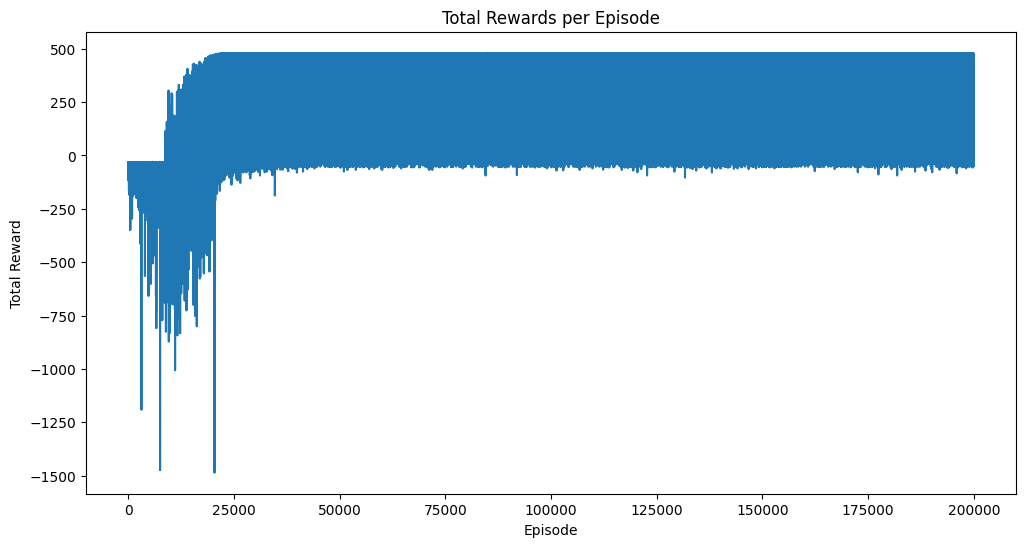

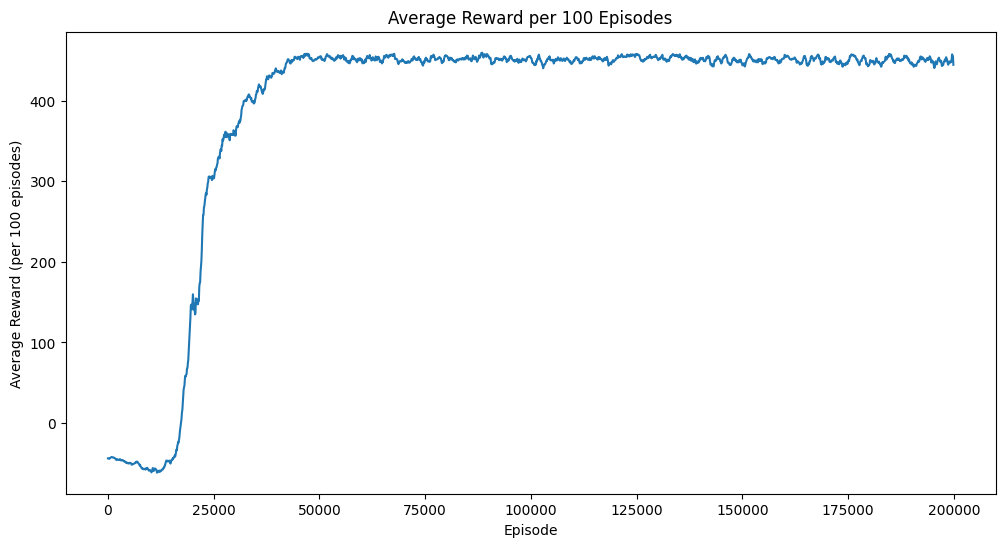

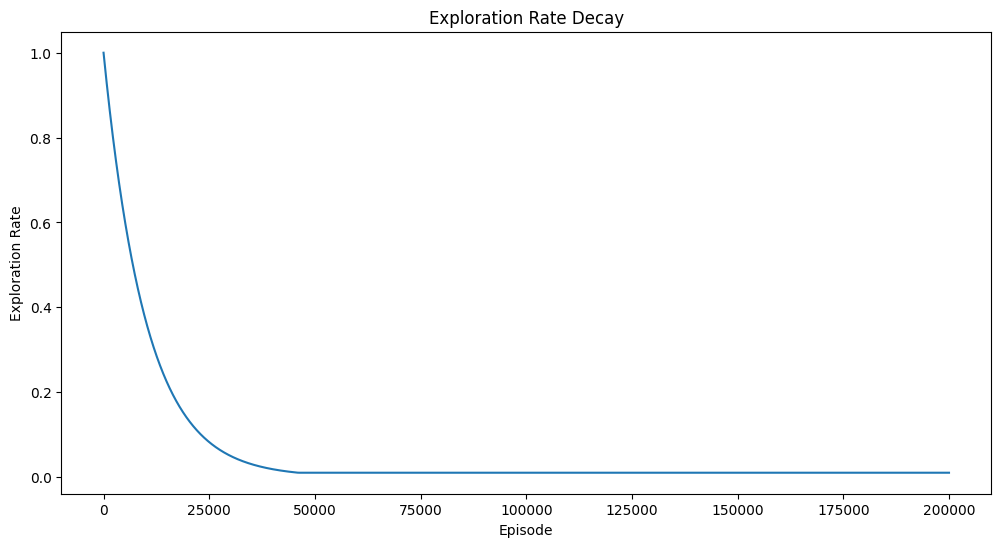

Final Total Reward: 471
Average Reward: 391.14675


In [ ]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import time

class QuadrupleQLearningAgent:
    def __init__(self, env, learning_rate=0.08, discount_factor=0.90, exploration_rate=1.0, exploration_decay=0.9999, min_exploration_rate=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(4))
        self.q_table2 = defaultdict(lambda: np.zeros(4))
        self.q_table3 = defaultdict(lambda: np.zeros(4))
        self.q_table4 = defaultdict(lambda: np.zeros(4))
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])
        else:
            q_values = self.q_table1[state] + self.q_table2[state] + self.q_table3[state] + self.q_table4[state]
            return np.argmax(q_values)

    def update_q_tables(self, state, action, reward, next_state):
        update_choice = random.randint(1, 4)
        if update_choice == 1:
            best_next_action = np.argmax(self.q_table2[next_state] + self.q_table3[next_state] + self.q_table4[next_state])
            td_target = reward + self.discount_factor * self.q_table2[next_state][best_next_action]
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        elif update_choice == 2:
            best_next_action = np.argmax(self.q_table1[next_state] + self.q_table3[next_state] + self.q_table4[next_state])
            td_target = reward + self.discount_factor * self.q_table1[next_state][best_next_action]
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error
        elif update_choice == 3:
            best_next_action = np.argmax(self.q_table1[next_state] + self.q_table2[next_state] + self.q_table4[next_state])
            td_target = reward + self.discount_factor * self.q_table1[next_state][best_next_action]
            td_error = td_target - self.q_table3[state][action]
            self.q_table3[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(self.q_table1[next_state] + self.q_table2[next_state] + self.q_table3[next_state])
            td_target = reward + self.discount_factor * self.q_table1[next_state][best_next_action]
            td_error = td_target - self.q_table4[state][action]
            self.q_table4[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Rewards per Episode')
        plt.show()

        avg_rewards = [np.mean(self.rewards_per_episode[i:i+1000]) for i in range(0, len(self.rewards_per_episode), 100)]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Average Reward (per 100 episodes)')
        plt.title('Average Reward per 100 Episodes')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel('Episode')
        plt.ylabel('Exploration Rate')
        plt.title('Exploration Rate Decay')
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Average Reward: {average_reward}")

env = ComplexPlatformEnv()
agent = QuadrupleQLearningAgent(env)
agent.train(episodes=200000)
agent.plot_performance()